<a href="https://colab.research.google.com/github/Kike-Ramirez/FarmDisco/blob/main/Background_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Background removing



### **Let's start!**

## 1. Preparation

<p align="justify">In the top menu of this session, select <b>Runtime -> Change runtime type</b>, and set <b>Hardware Accelerator</b> to <b>GPU</b>.</p>

<p align="justify">Clone the repository, and download the pre-trained model:</p>


In [ ]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 276 (delta 0), reused 1 (delta 0), pack-reused 273
Receiving objects: 100% (276/276), 60.77 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/MODNet
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 26.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Upload Images

<p align="justify">Upload portrait images to be processed (only PNG and JPG format are supported):</p>

In [ ]:
import shutil
import os
from google.colab import files

# clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

# upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))


KeyboardInterrupt: ignored

## 3. Inference

<p align="justify">Run the following command for alpha matte prediction:</p>

In [ ]:

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: Farm_bn_big.png


## 4. Visualization

<p align="justify">Display the results (from left to right: image, foreground, and alpha matte):</p>

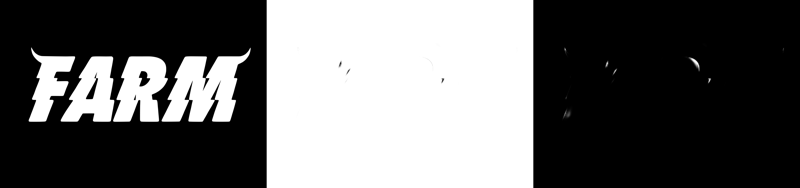

Farm_bn_big.png 



In [ ]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  alpha_name = image_name.split('.')[0] + '_alpha.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  image_alpha = image.copy()
  image_alpha.putalpha(matte)
  image_alpha.save(os.path.join(output_folder, alpha_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


## Download Results

<p align="justify">Download the Zip package of predicted alpha mattes:</p>

In [ ]:
zip_filename = 'matte.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {output_folder}/*")
files.download(zip_filename)